In [ ]:
!pip install snntorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.3/125.3 kB 3.5 MB/s eta 0:00:00


In [ ]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision import utils as utls

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

import torchvision.transforms as transforms
import torch.optim as optim

from torch.utils.data import DataLoader,Dataset

import snntorch as snn
from snntorch import utils
from snntorch import surrogate

import matplotlib.pyplot as plt
import numpy as np

import os
import io

In [ ]:
import pandas as pd

from google.colab import drive
drive.mount("/content/gdrive/")

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
root_dir = os.path.join(os.getcwd(), '/content/gdrive/My Drive/', 'Colab Notebooks/')
result_dir = os.path.join(root_dir, f'DeepLearning_FinalProject')

# make dir
os.makedirs(result_dir, exist_ok=True)

In [ ]:
class NoisyDataset(Dataset):

    def __init__(self, dataset, transform=None):
        self.trainset = dataset

    def __len__(self):
        return len(self.trainset)

    def transform(self, x):
        #print(x.shape)
        #for j in range(20):
          #for i in range(20):
            #p = np.random.randint(0,27)
            #q = np.random.randint(0,27)
            #x[0,p,q] = x[0,p,q]  + np.random.rand(1)

        x = x + np.random.random((x.shape[-2],x.shape[-1]))*0.5
        #dat_noisy = torch.from_numpy(dat_np)
        return x.float()

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img, _ = self.trainset[idx]

        #print(self.transform(img).shape)
        #sample = self.trainset[idx]
        sample = self.transform(img)

        return sample, self.trainset[idx][0]

In [ ]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [ ]:
#Spiking AutoEncoder
class SAE(nn.Module):
    def __init__(self):
        super().__init__()
        #Encoder
        self.encoder = nn.Sequential(nn.Conv2d(1, 32, 3,padding = 1,stride=2),
                          nn.BatchNorm2d(32),
                          snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True,threshold=thresh),
                          nn.Conv2d(32, 64, 3,padding = 1,stride=2),
                          nn.BatchNorm2d(64),
                          snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True,threshold=thresh),
                          nn.Conv2d(64, 128, 3,padding = 1,stride=2),
                          nn.BatchNorm2d(128),
                          snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True,threshold=thresh),
                          nn.Flatten(start_dim = 1, end_dim = 3),
                          nn.Linear(2048, latent_dim), #this needs to be the final layer output size (channels * pixels * pixels)
                          snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True,threshold=thresh)
                          )
       # From latent back to tensor for convolution
        self.linearNet = nn.Sequential(nn.Linear(latent_dim,128*4*4),
                               snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True,threshold=thresh))        #Decoder

        self.decoder = nn.Sequential(nn.Unflatten(1,(128,4,4)),
                          snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True,threshold=thresh),
                          nn.ConvTranspose2d(128, 64, 3,padding = 1,stride=(2,2),output_padding=1),
                          nn.BatchNorm2d(64),
                          snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True,threshold=thresh),
                          nn.ConvTranspose2d(64, 32, 3,padding = 1,stride=(2,2),output_padding=1),
                          nn.BatchNorm2d(32),
                          snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True,threshold=thresh),
                          nn.ConvTranspose2d(32, 1, 3,padding = 1,stride=(2,2),output_padding=1),
                          snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True,output=True,threshold=20000) #make large so membrane can be trained
                          )
    def forward(self, x):
        utils.reset(self.encoder) #need to reset the hidden states of LIF
        utils.reset(self.decoder)
        utils.reset(self.linearNet)

        #encode
        spk_mem=[];spk_rec=[];encoded_x=[]
        for step in range(num_steps): #for t in time
            spk_x,mem_x=self.encode(x) #Output spike trains and neuron membrane states
            spk_rec.append(spk_x)
            spk_mem.append(mem_x)
        spk_rec=torch.stack(spk_rec,dim=2)
        spk_mem=torch.stack(spk_mem,dim=2)

        #decode
        spk_mem2=[];spk_rec2=[];decoded_x=[]
        for step in range(num_steps): #for t in time
            x_recon,x_mem_recon=self.decode(spk_rec[...,step])
            spk_rec2.append(x_recon)
            spk_mem2.append(x_mem_recon)
        spk_rec2=torch.stack(spk_rec2,dim=4)
        spk_mem2=torch.stack(spk_mem2,dim=4)
        out = spk_mem2[:,:,:,:,-1] #return the membrane potential of the output neuron at t = -1 (last t)
        return out

    def encode(self,x):
        spk_latent_x,mem_latent_x=self.encoder(x)
        return spk_latent_x,mem_latent_x

    def decode(self,x):
        spk_x,mem_x = self.linearNet(x) #convert latent dimension back to total size of features in encoder final layer
        spk_x2,mem_x2=self.decoder(spk_x)
        return spk_x2,mem_x2

In [ ]:
#Training
def train(network, trainloader, opti, epoch):

    network=network.train()
    train_loss_hist=[]
    for batch_idx, (noisy_img, real_img) in enumerate(trainloader):
        opti.zero_grad()
        real_img = real_img.to(device)
        noisy_img = noisy_img.to(device)

        #Pass data into network, and return reconstructed image from Membrane Potential at t = -1
        x_recon = network(noisy_img) #Dimensions passed in: [Batch_size,Channels,Image_Width,Image_Length]

        #Calculate loss
        loss_val = F.mse_loss(x_recon, real_img)

        print(f'Train[{epoch}/{max_epoch}][{batch_idx}/{len(trainloader)}] Loss: {loss_val.item()}')

        loss_val.backward()
        opti.step()

        #Save reconstructed images every at the end of the epoch
        if batch_idx == len(trainloader)-1:
            # NOTE: you need to create training/ and testing/ folders in your chosen path
            #utls.save_image((real_img+1)/2, f'training/epoch{epoch}_finalbatch_inputs.png')
            #utls.save_image((x_recon+1)/2, f'training/epoch{epoch}_finalbatch_recon.png')
            pass
    return loss_val

In [ ]:
#Testing
def test(network, testloader, opti, epoch):
    network=network.eval()
    test_loss_hist=[]
    with torch.no_grad(): #no gradient this time
        for batch_idx, (noisy_img, real_img) in enumerate(testloader):
            real_img = real_img.to(device)#
            noisy_img = noisy_img.to(device)
            #labels = labels.to(device)
            x_recon = network(noisy_img)

            loss_val = F.mse_loss(x_recon, real_img)

            print(f'Test[{epoch}/{max_epoch}][{batch_idx}/{len(testloader)}]  Loss: {loss_val.item()}')#, RECONS: {recons_meter.avg}, DISTANCE: {dist_meter.avg}')

            if batch_idx == len(testloader)-1:
                #utls.save_image((real_img+1)/2, f'testing/epoch{epoch}_finalbatch_inputs.png')
                #utls.save_image((x_recon+1)/2, f'testing/epoch{epoch}_finalbatch_recons.png')
                pass
    return loss_val

# Dataset Generate

In [ ]:
# Parameters and Run training and testing
batch_size = 250
input_size = 32 #size of input to first convolutional layer

#setup GPU
dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Load MNIST
train_dataset = datasets.MNIST(root='dataset/', train=True, transform=transforms.Compose([transforms.ToTensor(),transforms.Resize((input_size, input_size)),transforms.Normalize((0,), (1,))]), download=True)
#train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
train_dset = NoisyDataset(train_dataset)
train_loader = DataLoader(train_dset, batch_size=batch_size, shuffle=True)

test_dataset = datasets.MNIST(root='dataset/', train=False, transform=transforms.Compose([transforms.ToTensor(),transforms.Resize((input_size, input_size)),transforms.Normalize((0,), (1,))]), download=True)
test_dset = NoisyDataset(test_dataset)
test_loader = DataLoader(test_dset, batch_size=batch_size, shuffle=True)
#test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 57.1MB/s]


Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.72MB/s]

Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 13.7MB/s]


Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.14MB/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



In [ ]:
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True,
                                        transform=transforms.ToTensor())
trainset = NoisyDataset(trainset)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

In [ ]:
testset = torchvision.datasets.MNIST(root='./data', train=True, download=True,
                                        transform=transforms.ToTensor())
testset = NoisyDataset(testset)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=True)

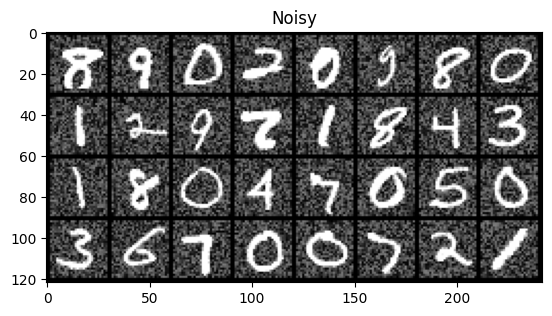

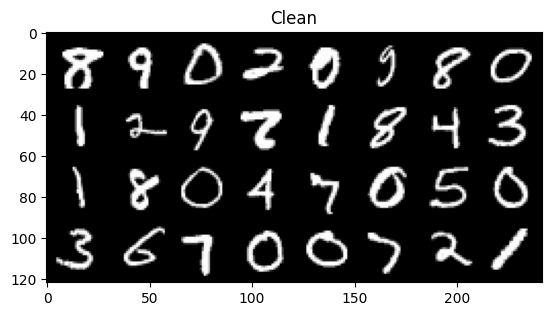

In [ ]:
noisy_dat, clean_dat = next(iter(trainloader))
plt.title('Noisy')
imshow(torchvision.utils.make_grid(noisy_dat.detach().to('cpu')))
plt.title('Clean')
imshow(torchvision.utils.make_grid(clean_dat.detach().to('cpu')))

# Main

In [ ]:
# SNN parameters
spike_grad = surrogate.atan(alpha=2.0)# alternate surrogate gradient: fast_sigmoid(slope=25)
beta = 0.5 #decay rate of neurons
num_steps=5 #time
latent_dim = 32 #dimension of latent layer (how compressed we want the information)
thresh=1#spiking threshold (lower = more spikes are let through)
epochs=100 #number of epochs
max_epoch=epochs

In [ ]:
#Define Network and optimizer
net=SAE()
net = net.to(device)

optimizer = torch.optim.AdamW(net.parameters(),
                            lr=0.0001,
                            betas=(0.9, 0.999),
                            weight_decay=0.001)

In [ ]:
# Load pretrained model
net = SAE()
net = net.to(device)
net.load_state_dict(torch.load(os.path.join(result_dir, 'model.pt'), weights_only=True))

<All keys matched successfully>

In [ ]:
#Run training and testing
for e in range(epochs):
    train_loss = train(net, train_loader, optimizer, e)
    test_loss = test(net,test_loader,optimizer,e)

# Uncomment the below line to save the model
#torch.save(net.state_dict(), os.path.join(result_dir, 'model2.pt'))

Streaming output truncated to the last 5000 lines.
Train[82/100][40/240] Loss: 0.01036317553371191
Train[82/100][41/240] Loss: 0.0099180331453681
Train[82/100][42/240] Loss: 0.009946064092218876
Train[82/100][43/240] Loss: 0.010402308776974678
Train[82/100][44/240] Loss: 0.010456468909978867
Train[82/100][45/240] Loss: 0.010209398344159126
Train[82/100][46/240] Loss: 0.010418896563351154
Train[82/100][47/240] Loss: 0.009961397387087345
Train[82/100][48/240] Loss: 0.01020741369575262
Train[82/100][49/240] Loss: 0.01010996475815773
Train[82/100][50/240] Loss: 0.00991132389754057
Train[82/100][51/240] Loss: 0.010047731921076775
Train[82/100][52/240] Loss: 0.010325397364795208
Train[82/100][53/240] Loss: 0.009853229857981205
Train[82/100][54/240] Loss: 0.009906712919473648
Train[82/100][55/240] Loss: 0.009778439067304134
Train[82/100][56/240] Loss: 0.010029744356870651
Train[82/100][57/240] Loss: 0.010272023268043995
Train[82/100][58/240] Loss: 0.010661452077329159
Train[82/100][59/240] Lo

# Testing

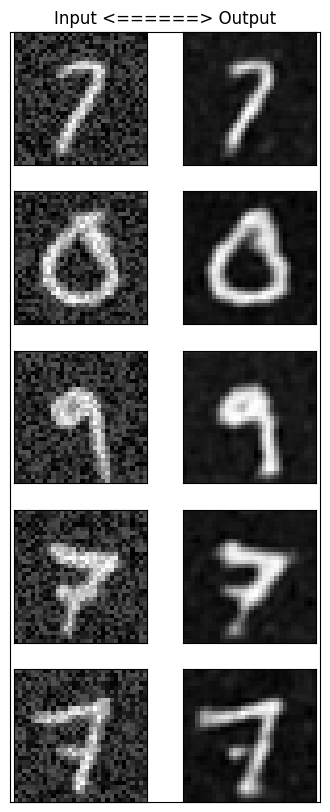

In [ ]:
# Calling the test data loader
data = next(iter(test_loader))[0].float().to(device)
output = net(data)

# select the first 10 samples in the batch to visualize in the grid plots below
idx = 1
plt.figure(figsize=(4,10))
plt.title('Input <======> Output')
plt.xticks([])
plt.yticks([])
for i in range(5):
  plt.subplot(5,2,idx)
  plt.imshow(data[i].cpu().detach().numpy()[0], cmap='gray')
  plt.xticks([])
  plt.yticks([])

  plt.subplot(5,2,idx+1)
  plt.imshow(output[i].cpu().detach().numpy()[0], cmap='gray')
  plt.xticks([])
  plt.yticks([])

  idx+=2

plt.show()

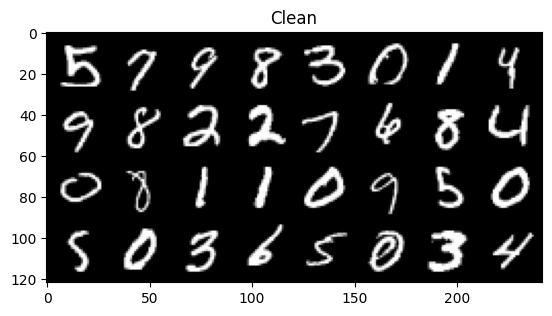

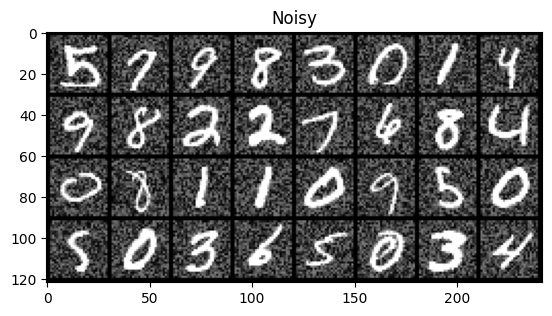

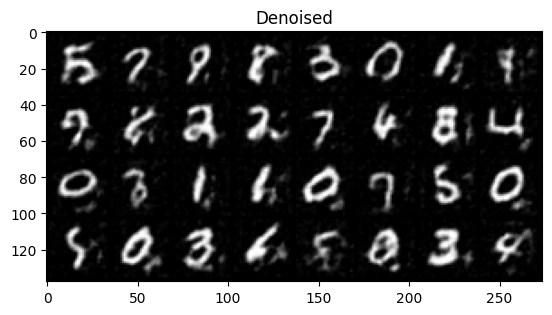

In [ ]:
#data = next(iter(test_loader))[0].float().to(device)
images_noisy, clean = next(iter(testloader))

plt.title('Clean')
imshow(torchvision.utils.make_grid(clean))

plt.title('Noisy')
imshow(torchvision.utils.make_grid(images_noisy))

images_noisy = images_noisy.float().to(device)

outputs = net(images_noisy)
plt.title('Denoised')
imshow(torchvision.utils.make_grid(outputs.detach().to('cpu')))